# Ground-roll attenuation model

## Content
* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Hyperparameters estimation](#Hyperparameters-estimation)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Problem description

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. The model should suppress the ground-roll noise and keep desired signal unchanged.

## Dataset

We exploit the Dataset 1 from a list of dataset on ground-roll attenuation. Description of the Dataset 1 is available [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/noise_attenuation.ipynb). 5 first seismograms of the train part we keep for model training, the rest ones for testing. 

Index field records:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

sys.path.append('../..')

from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline, B, V, F
from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex,
                            seismic_plot, spectrum_plot, merge_segy_files,
                            time_statistics, spectral_statistics,
                            show_statistics)

%env CUDA_VISIBLE_DEVICES=7

path_raw = '/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw',
                    extra_headers=['offset', 'INLINE_3D', 'CROSSLINE_3D'],
                    path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))

index.head()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


env: CUDA_VISIBLE_DEVICES=7


,offset,INLINE_3D,CROSSLINE_3D,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,,,raw,raw,lift,lift
FieldRecord,,,,,,,,
111906,35,1617,550,1656,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,1,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy
111906,36,1617,551,1657,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,2,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy
111906,78,1617,549,1655,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,3,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy
111906,79,1617,552,1658,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,4,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy
111906,127,1617,548,1654,5,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,5,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy


Sample raw and target field record:

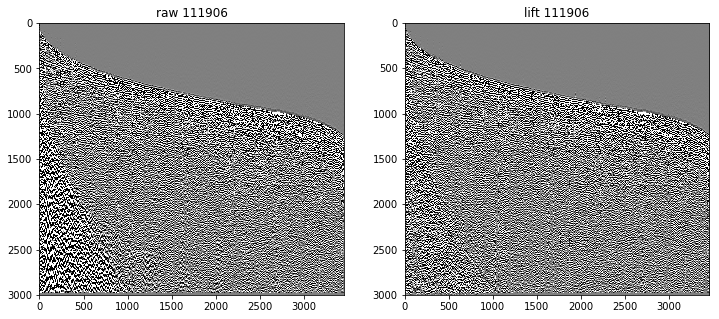

In [2]:
cv = 0.1
(Dataset(index, SeismicBatch).next_batch(1)
         .load(components=('raw', 'lift'), fmt='segy')
         .seismic_plot(('raw', 'lift'), index.indices[0],
                       figsize=(12, 5), vmin=-cv, vmax=cv, cmap='gray'))

Selecting field records and traces for model training:

In [3]:
train_index = index.create_subset(index.indices[:5])
train_set = Dataset(TraceIndex(train_index), SeismicBatch)

Selecting field records for model testing:

In [17]:
test_index = index.create_subset(index.indices[5:])

## Model architecture

We exploit a convolutional neural network of the U-net type with depth 4 and the following config:

Layouts:
* encoder: Conv1d - Activation - Conv1d - Activation
* downsampling: MaxPooling1d - Dropout
* decoder: Conv1d - Activation - Conv1d - Activation
* upsampling: TransposedConv1d - Activation - Dropout

Convolutions (Conv1d, TransposedConv1d):
* ```filters``` = 16 * 2**i, i is a encoder (decoder) depth level, varies from 0 to 3.
* ```kernel_size``` = 7
* ```strides``` = 2
* ```padding``` = ```'same'```
* ```data_format``` = ```'channels_last'```
* ```activation``` = None

MaxPooling1d:
* ```pool_size``` = 2
* ```pool_strides``` = 1.

Activation:
* ```activation``` = ```tf.nn.elu```

Dropout:
* ```dropout_rate```=0.05

Setting the model config:

In [5]:
model_config = {
    'initial_block/inputs': 'x',
    'inputs': dict(x={'shape': (3000, 1)}, 
                   y={'name':'targets', 'shape': (3000, 1)}),
    'body/filters': [16, 32, 64, 128, 256],
    'body/encoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
    'body/decoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/upsample': dict(layout='tad', kernel_size=7, strides=2,
                          dropout_rate=0.05, activation=tf.nn.elu),
    'loss':'l1',
    'optimizer': 'Adam'
}

## Hyperparameters estimation

See the [research notebook](https://github.com/analysiscenter/SeismicPro/blob/master/models/Ground-roll%20attenuation/parameters_estimation.ipynb) for investigation of ```filters``` and ```kernel_size``` influence on the model performance.

## Training

Training pipeline actions:
* loading a batch of raw and target traces
* model weights update

Optimizer configuration:
* optimizer: Adam
* learning_rate = 0.05

Loss fuction: ```l1```

Training scheme:
* ```batch_size``` = 64
* ```n_epochs``` = 10.

Setting a train pipeline:

In [6]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(np.vstack(batch.raw), -1),
                          'y': np.expand_dims(np.vstack(batch.lift), -1)}}

train_pipeline = (Pipeline()
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', UNet, 'unet', model_config)
                  .train_model('unet', make_data=make_data,
                               fetches='loss', save_to=V('loss'), mode='a')
                 )

Run the training pipeline

In [7]:
batch_size = 64

train_pipeline = train_pipeline << train_set
train_pipeline.run(batch_size, n_epochs=3, drop_last=True, shuffle=True, bar=True)

  0%|          | 0/810 [00:00<?, ?it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


100%|█████████▉| 809/810 [02:24<00:00,  5.87it/s]


Loss against iterations:

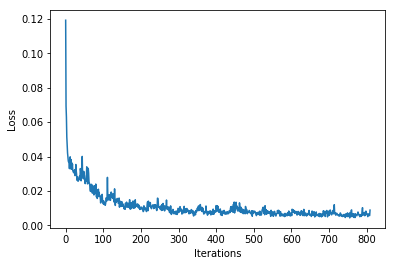

In [8]:
plt.plot(train_pipeline.get_variable("loss"))
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

Dump the model:

In [11]:
train_pipeline.save_model('unet', './unet_model')

## Inference

Imference pipeline:

In [12]:
model_config = {
    "build": False,
    "load": {"path": './unet_model'},
}

def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(np.vstack(batch.raw), -1)}}

def unstack_results(batch, arr):
    indices = np.cumsum([len(x) for x in batch.raw[:-1]])
    return np.array(np.split(arr, indices) + [None])[:-1]

dump_path = '/notebooks/egor/geolog/notebooks/dumps'

predict_pipeline = (Pipeline()
                    .load(components='raw', fmt='segy', tslice=np.arange(3000))
                    .init_model("static", UNet, 'unet', config=model_config)
                    .init_variable('res')
                    .init_variable('count', init_on_each_run=0)
                    .predict_model('unet', fetches='predictions', 
                                   make_data=make_data, save_to=V('res'))
                    .call(unstack_results, arr=V('res'), save_to=B('raw'))
                    .dump(fmt='segy', path=F(lambda _, x: os.path.join(dump_path, str(x) + '.sgy'), V('count')),
                          src='raw', split=False)
                    .update_variable('count', F(lambda _, x: x + 1, V('count')))
                   )

INFO:tensorflow:Restoring parameters from ./unet_model/model-810


Run the pipeline on the whole dataset:

In [13]:
batch_size = 1000
predict_pipeline = predict_pipeline << Dataset(TraceIndex(index), SeismicBatch)
predict_pipeline.run(batch_size, n_epochs=1, drop_last=False, shuffle=False, bar=True)

 99%|█████████▉| 175/176 [02:39<00:00,  1.09it/s]


Merge dumped segy files into one:

In [14]:
merge_segy_files(path=os.path.join(dump_path, '*sgy'),
                 output_path='/notebooks/egor/geolog/notebooks/merged.sgy')

## Running time

System config:
* GPU: GTX GeForce 1080
* CPU(s): 40
* Model name: Intel Xeon E5-2630

Time performance:
* Single model training iteration with batch size=64: 0.17 sec.
* Inference of 1000 traces: 0.9 sec.

## Model evaluation

The [model estimation notebook](https://github.com/analysiscenter/SeismicPro/blob/master/models/Ground-roll%20attenuation/parameters_estimation.ipynb) demonstrates variability of `l1` metrics on the test dataset across multiple model initializations. The average (median) `l1` value is found to be 0.0064 with standard deviatin of 0.0004.

For detailed model evaluation we
* select sample test seismograms and compare signal power spectrum with tragest seismogram
* select sample test seismograms and consider statistics distribution over traces in time and frequency domain.

Inference pipeline for model evaluation:

In [15]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(np.vstack(batch.raw), -1)}}

predict_pipeline = (Pipeline()
                    .import_model('unet', train_pipeline)
                    .init_variable('res', init_on_each_run=list())
                    .init_variable('raw', init_on_each_run=list())
                    .init_variable('lift', init_on_each_run=list())
                    .load(components=('raw', 'lift'), tslice=np.arange(3000),
                          fmt='segy')
                    .update_variable('raw', B('raw'), mode='a')
                    .update_variable('lift', B('lift'), mode='a')
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('res'), mode='a')
                   )

Select a sample test seismogram and define a dataset:

In [18]:
sample_index = test_index.create_subset(test_index.indices[20:21])
test_set = Dataset(TraceIndex(sample_index), SeismicBatch)

Run the inference pipeline on the sample seismogram:

In [19]:
predict_pipeline = predict_pipeline << test_set
predict_pipeline.run(batch_size=1000, n_epochs=1, drop_last=False, shuffle=False, bar=True)

 75%|███████▌  | 3/4 [00:01<00:00,  2.16it/s]


Arrange results:

In [20]:
res = np.squeeze(np.vstack(predict_pipeline.get_variable("res")), axis=-1)
raw = np.vstack(np.concatenate(predict_pipeline.get_variable("raw")))
lift = np.vstack(np.concatenate(predict_pipeline.get_variable("lift")))

Show raw traces, model output and difference between them:

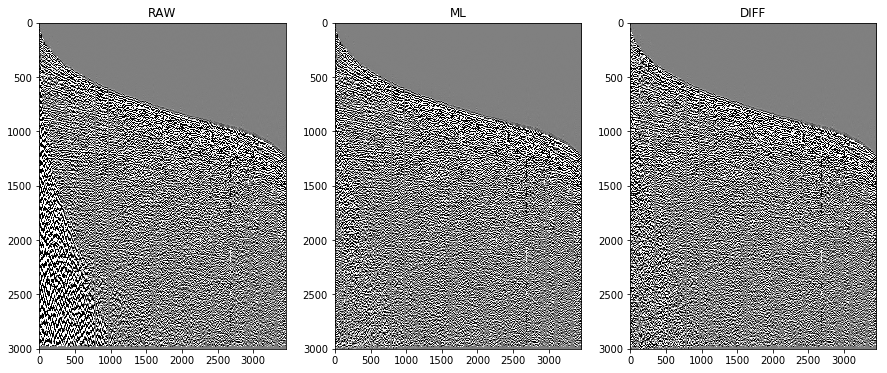

In [21]:
seismic_plot([raw, res, lift], names=['RAW', 'ML', 'DIFF'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

Show model output, traget seismogram difference between them:

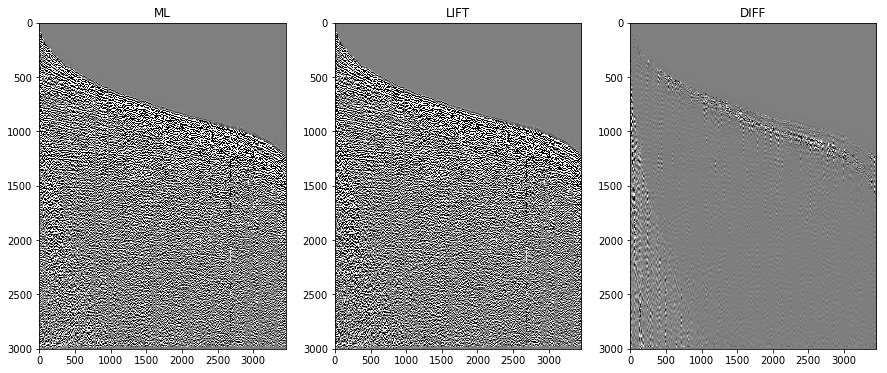

In [22]:
seismic_plot([res, lift, res - lift], names=['ML', 'LIFT', 'DIFF'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

Power spectrum comparison in ground-roll region:

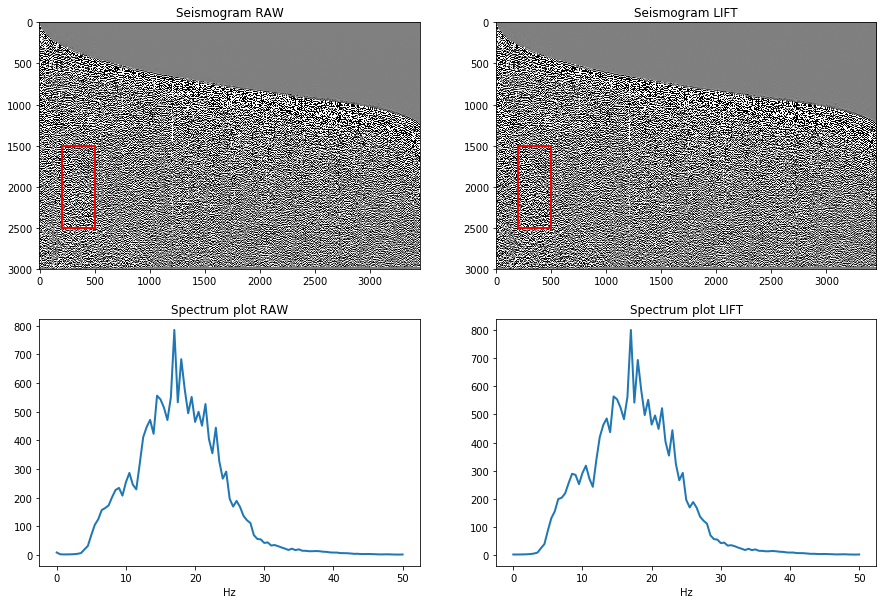

In [25]:
spectrum_plot([res, lift], frame=(slice(200, 500), slice(1500, 2500)), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['RAW', 'LIFT'])

Power spectrum comparison out of ground-roll region:

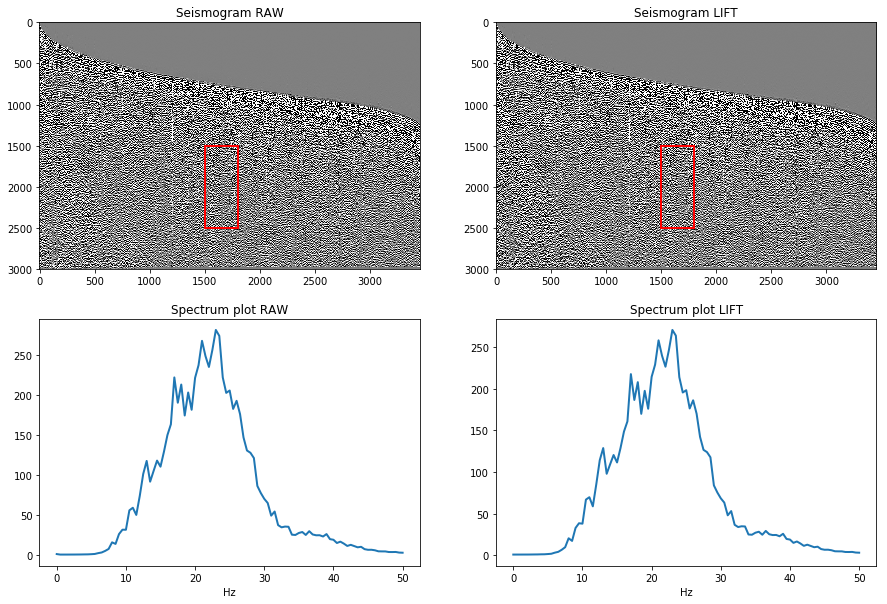

In [26]:
spectrum_plot([res, lift], frame=(slice(1500, 1800), slice(1500, 2500)), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['RAW', 'LIFT'])

Model output statistics in time domain:

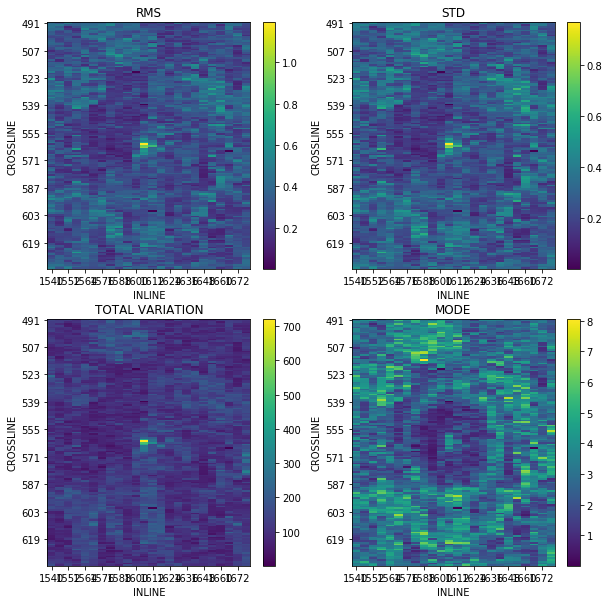

In [27]:
stats = time_statistics(res)
iline = test_set.index.get_df()['INLINE_3D']
xline = test_set.index.get_df()['CROSSLINE_3D']
titles = ['RMS', 'STD', 'TOTAL VARIATION', 'MODE']
show_statistics(stats, iline=iline, xline=xline, titles=titles,
                nrows=2, ncols=2, figsize=(10, 10))

Model output statistics in frequency domain:

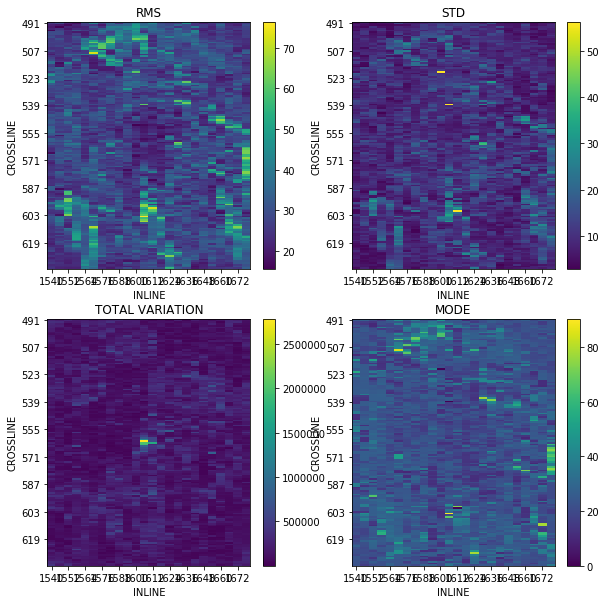

In [28]:
stats = spectral_statistics(res, rate=0.002)
show_statistics(stats, iline=iline, xline=xline, titles=titles,
                nrows=2, ncols=2, figsize=(10, 10))

Model output and target signal difference statistics in time domain:

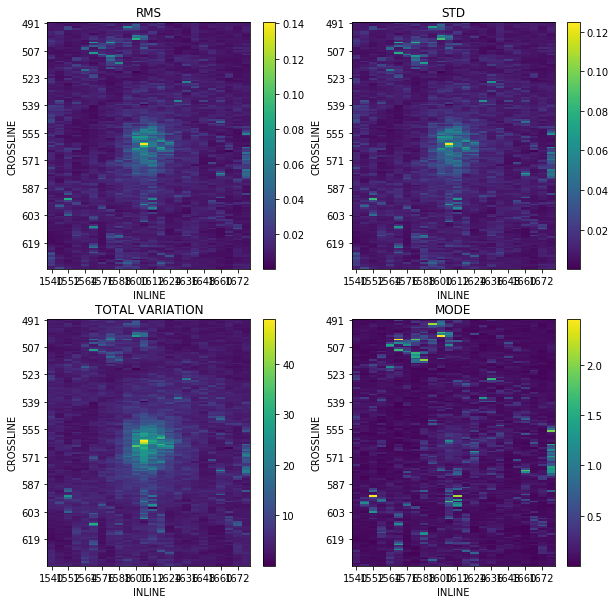

In [29]:
stats = time_statistics(res - lift)
show_statistics(stats, iline=iline, xline=xline, titles=titles,
                nrows=2, ncols=2, figsize=(10, 10))

Model output and target signal difference statistics in frequency domain:

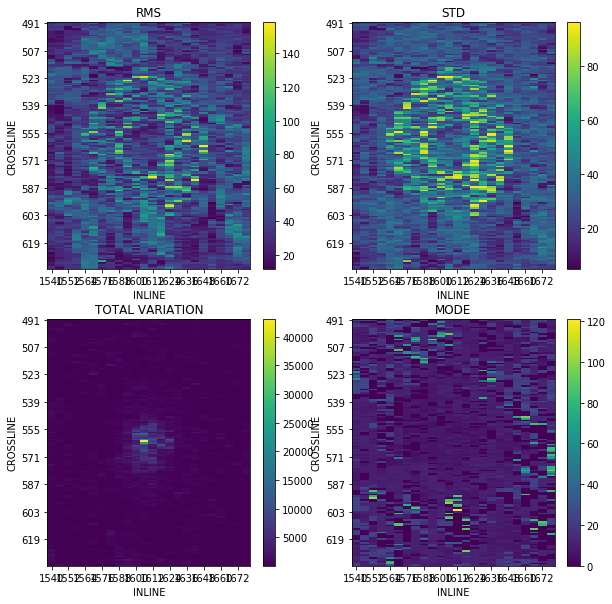

In [30]:
stats = spectral_statistics(res - lift, rate=0.002)
show_statistics(stats, iline=iline, xline=xline, titles=titles,
                nrows=2, ncols=2, figsize=(10, 10))

## Criticism

The plots with statistics distribution demonstrate outlier traces with e.g. increased dominant frequency and signal amptitudes. Such outliers will strongly affect stacked seismogram. 

## Conclusion

The model reduces the ground-rol noise and shows similar to target power spectrum both in ground-roll region and outside it. However, we observe a number of outliers, e.g. traces with substantially increased dominant frequency and signal amptitudes. This is probably a manifestation of the 1D model architecture. Anyway, this effect is undesired for the processsed seismogram.

## Suggestions for improvements

Natural suggestion is to consider multychannel models that take into account neighbouring traces.